In [1]:
import torch
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from data import get_dataset, get_trajectory, get_field, dynamics_fn
import os, sys
sys.path.append(os.path.abspath('..'))

from hnn import HNN
from trainer import Trainer

In [2]:
data = get_dataset(test_split=0.8)

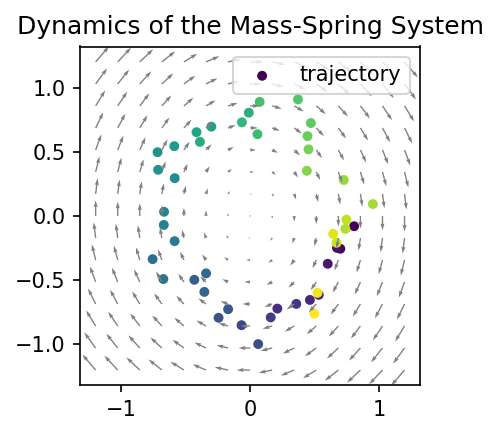

In [ ]:
# Noisy observation of dataset

field = get_field(gridsize=15)

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=150)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1, 0]))
plt.scatter(x, y, c=t, s=14, label='trajectory')
plt.quiver(field['x'][:, 0], field['x'][:, 1], field['dx'][:, 0], field['dx'][:, 1],
           cmap='gray_r', color=(.5, .5, .5))

plt.xlabel("", fontsize=14)
plt.ylabel("", rotation=0, fontsize=14)
plt.title("Dynamics of the Pendulum")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [4]:
train_x, train_y = torch.tensor(data['x'], dtype=torch.float32), torch.tensor(data['dx'], dtype=torch.float32)
test_x, test_y   = torch.tensor(data['test_x'], dtype=torch.float32), torch.tensor(data['test_dx'], dtype=torch.float32)


In [5]:
model = HNN(d_hidden=64)
trainer = Trainer(model)

In [6]:
trainer.fit(train_x, train_y, epochs=100) #  Optional : verbose = True

--------------------------------------------------------
Summary : 
Total epochs : 100, minimum loss : 0.3124


In [7]:
model_pred = trainer.predict(test_x).detach().numpy()
model_pred.shape

(450, 2)

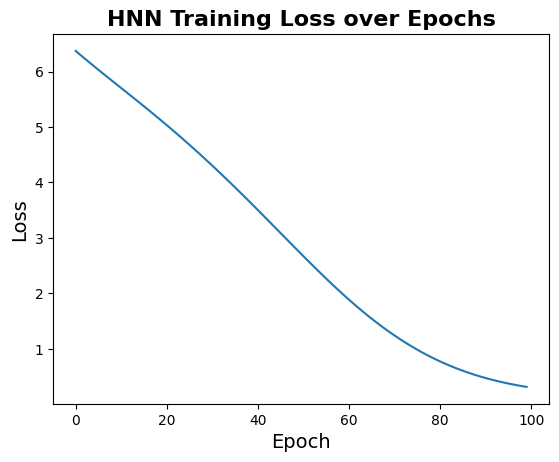

In [8]:
losses = trainer.losses
plt.title('HNN Training Loss over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.plot(losses)

# here we are simulating the full experiment

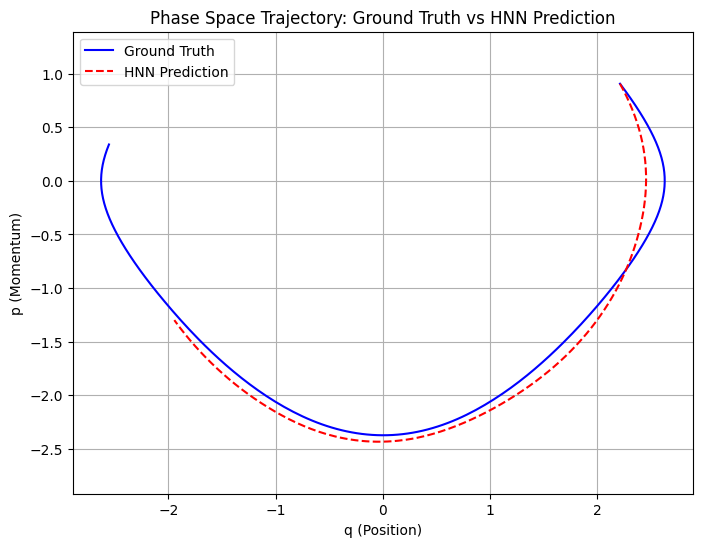

In [9]:
def learned_dynamics(t, y):
    y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=True).unsqueeze(0)
    dydt = model.symplectic_gradient(y_tensor).squeeze().detach().numpy()
    return dydt


y0 = test_x[0].detach().numpy() # initial state
t_span = [0, 3] # simulating from time 0 to 3
t_eval = np.linspace(*t_span, 300)


# Ground truth trajectory
gt_ivp = solve_ivp(dynamics_fn, t_span, y0, t_eval=t_eval)

# Learned HNN trajectory
learned_ivp = solve_ivp(learned_dynamics, t_span, y0, t_eval=t_eval)



# Plot the phase space (q vs p)
plt.figure(figsize=(8, 6))
plt.plot(gt_ivp.y[0], gt_ivp.y[1], label='Ground Truth', color='blue')
plt.plot(learned_ivp.y[0], learned_ivp.y[1], '--', label='HNN Prediction', color='red')
plt.xlabel('q (Position)')
plt.ylabel('p (Momentum)')
plt.title('Phase Space Trajectory: Ground Truth vs HNN Prediction')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()